# Machine Learning Template


In [1]:
import datetime
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


from src.ml_template import utils

from scipy.cluster import hierarchy
from scipy.spatial.distance import squareform


from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.feature_selection import RFECV
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import accuracy_score, root_mean_squared_error, r2_score
from sklearn.inspection import permutation_importance
from sklearn.neural_network import MLPRegressor
import shap

import statsmodels.api as sm


import xgboost as xgb

import seaborn as sns



c:\Users\nied\Documents\work\ml_template\.venv_ml\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
features = pd.read_csv(r"\\umweltbundesamt.at\Projekte\3000\3135_IntMon\Intern\ARCHneu\UBA_IM\Themen_nach_Projektbereichen\PB2\2025_26_Auswertung_C_H2O_Duerre\Ergebnisse\predictors_daily.txt", sep=';', parse_dates=True)
rproc = pd.read_csv(r"\\umweltbundesamt.at\Projekte\3000\3135_IntMon\Intern\ARCHneu\UBA_IM\Themen_nach_Projektbereichen\PB2\0000_EddyKovarianz\NEE_Partitioning\nee-partitioning\results\EddyProc\NEEpart.csv", parse_dates=True)
fsv_partitioned = glob.glob(r"\\umweltbundesamt.at\Projekte\3000\3135_IntMon\Intern\ARCHneu\UBA_IM\Themen_nach_Projektbereichen\PB2\0000_EddyKovarianz\NEE_Partitioning\nee-partitioning\results\fluxpart\fvs_partitioned_30min_*.txt")
fvs_partition_df = pd.concat([pd.read_csv(file, sep=';', parse_dates=['datetime']) for file in fsv_partitioned])

In [3]:
rproc = rproc[["GPP_DT", "Reco_DT"]].groupby(pd.to_datetime(rproc.datetime).dt.date).mean()

In [4]:
fluxpart = fvs_partition_df[["Fq_mmol", "Fqt_mmol", "Fqe_mmol", "Fc_umol", "Fcp_umol", "Fcr_umol"]].groupby(fvs_partition_df.datetime.dt.date).mean()
targets = rproc.merge(fluxpart, how='outer', left_index=True, right_index=True)

In [5]:
features["date"] = pd.to_datetime(features.day)
features.drop(columns='day', inplace=True)
features.set_index('date', inplace=True)

In [6]:
targets['NEE'] = targets.Reco_DT - targets.GPP_DT
targets['GPP/Trans'] = targets.Fcp_umol / targets.Fqt_mmol

In [7]:
df = features.merge(targets, how = 'right', left_index=True, right_index=True)

In [8]:
df.replace([np.inf, -np.inf], np.nan, inplace=True)
df['WaPo.day'] *= -1

In [9]:
df = df[df.index.date >= datetime.date(2018, 1, 1)]

In [10]:
df

,prec.ww,WaPo.day,temp.mt,temp.max.mt,temp.min.mt,vpd.mt,ppfd,gstr.mt.sum,GPP_DT,Reco_DT,Fq_mmol,Fqt_mmol,Fqe_mmol,Fc_umol,Fcp_umol,Fcr_umol,NEE,GPP/Trans
datetime,,,,,,,,,,,,,,,,,,
2018-01-01,4.3,100.0,4.466667,8.8,1.2,0.182703,3.37338,0,0.135079,2.865752,86.768026,0.127619,86.640407,7652.768751,-1.515487,7654.284238,2.730673,-11.875095
2018-01-02,5.7,100.0,1.704167,3.8,-0.7,0.159027,2.38860,0,0.080247,1.964051,157.348877,0.006103,157.342774,20600.456795,-0.092845,20600.549640,1.883804,-15.212891
2018-01-03,17.8,100.0,2.527083,8.4,0.3,0.184756,2.07990,0,0.097488,2.266728,377.815211,0.077767,377.737444,47998.880149,-0.917888,47999.798037,2.169240,-11.803027
2018-01-04,27.2,100.0,2.635417,5.1,0.5,0.128645,2.16198,0,0.086696,2.224099,42.819855,0.060712,42.759143,5642.934843,-1.208564,5644.143406,2.137402,-19.906366
2018-01-05,19.8,100.0,7.583333,11.9,5.2,0.143288,7.47630,0,0.443838,3.776254,372.542196,0.310266,372.231930,21454.386012,-3.677529,21458.063541,3.332416,-11.852834
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-12-27,0.7,100.0,6.239583,10.3,3.9,0.511158,3.98160,5392,4.647007,1.233309,NaN,NaN,NaN,NaN,NaN,NaN,-3.413698,NaN
2024-12-28,0.0,100.0,6.208333,10.5,2.6,0.410295,3.98376,5207,4.569692,1.261256,NaN,NaN,NaN,NaN,NaN,NaN,-3.308436,NaN
2024-12-29,0.0,100.0,5.614583,9.0,3.7,0.343098,3.94272,5443,4.667794,1.126886,NaN,NaN,NaN,NaN,NaN,NaN,-3.540908,NaN


In [27]:
df_d = df.resample('W').mean()

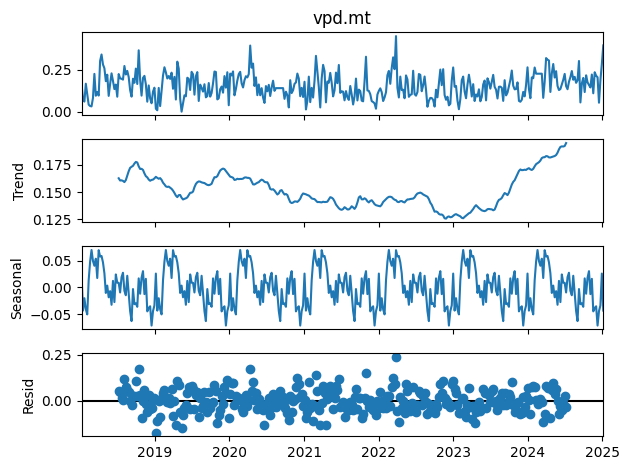

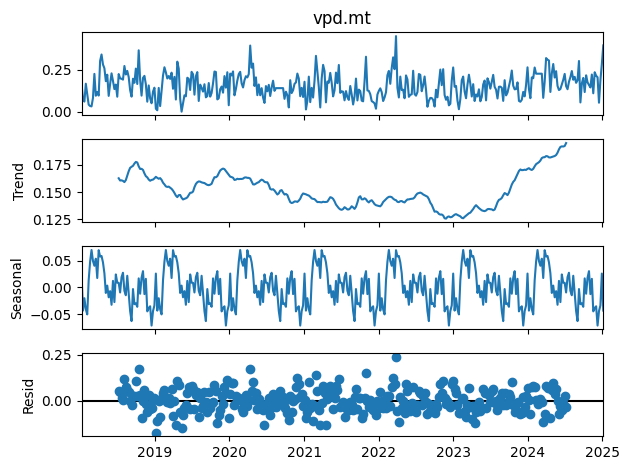

In [75]:
model = sm.tsa.seasonal_decompose(df_d['vpd.mt'].ffill(), model='additive')
model.plot()

In [54]:
trend = {}

for col in df_d.columns:
    model = sm.tsa.seasonal_decompose(df_d[col].fillna(method='ffill'), model='additive')
    trend[col] = model.trend


C:\Users\nied\AppData\Local\Temp\ipykernel_25984\2953522141.py:4: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  model = sm.tsa.seasonal_decompose(df_d[col].fillna(method='ffill'), model='additive')


In [67]:
trend_df = pd.DataFrame(trend)

<Axes: >

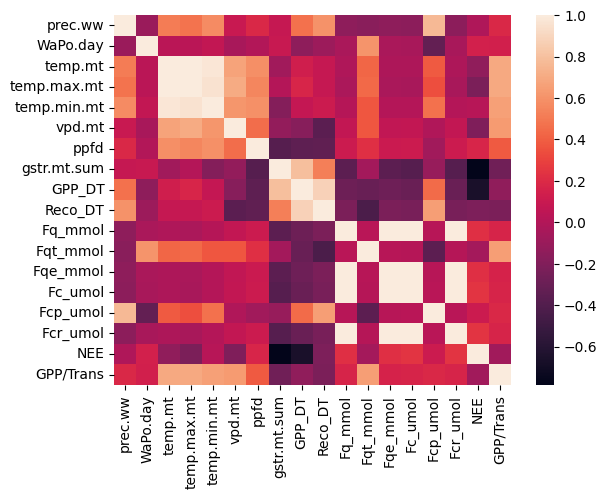

In [73]:
sns.heatmap(trend_df.corr())

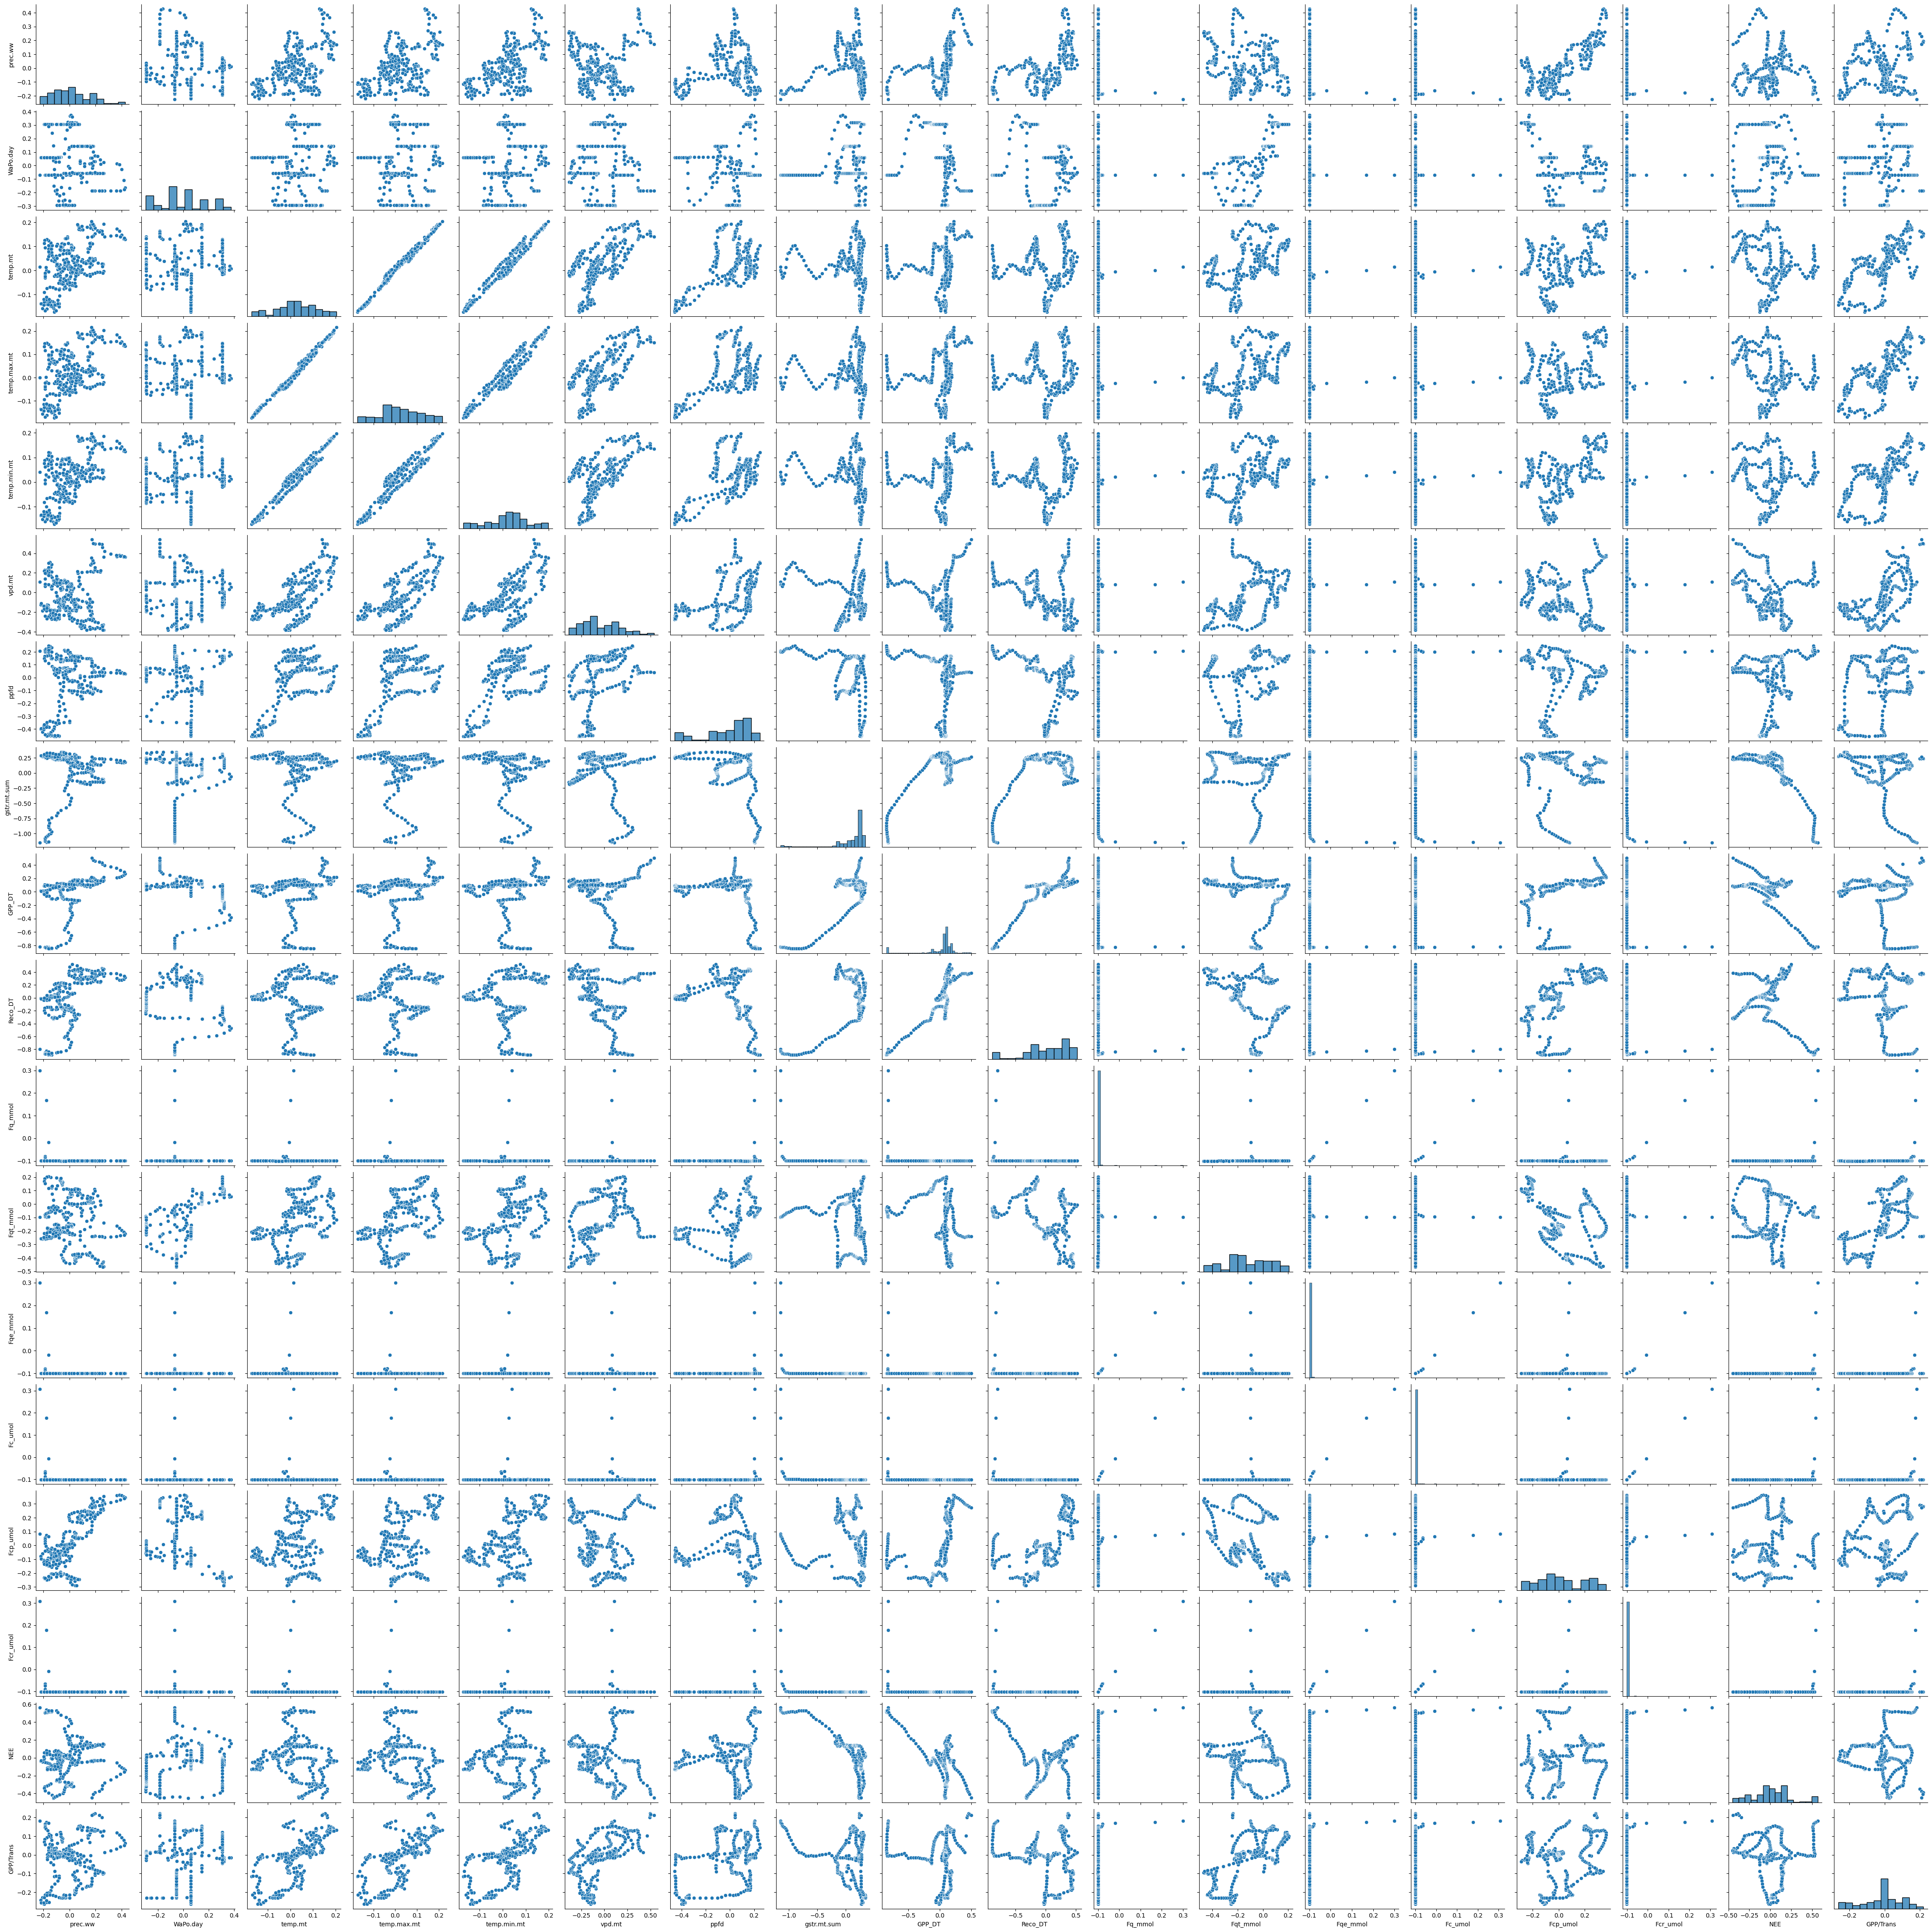

In [76]:
sns.pairplot((trend_df-df_d.mean())/df_d.std())

In [ ]:
# df.to_csv(r"P:\3000\3135_IntMon\Intern\ARCHneu\UBA_IM\Themen_nach_Projektbereichen\PB2\2025_26_Auswertung_C_H2O_Duerre\Ergebnisse\ml_df_2014_2024.txt", index=True, index_label='datetime', sep=';')
# df = pd.read_csv('ml_df_2014_2014.txt', sep=';', parse_dates=True, date_format="%Y-%m-%d")
# df["datetime"] = pd.to_datetime(df["datetime"])
# df.set_index('datetime', inplace=True)
# targets = df[['GPP_DT', 'Reco_DT',
#        'Fq_mmol', 'Fqt_mmol', 'Fqe_mmol', 'Fc_umol', 'Fcp_umol', 'Fcr_umol',
#        'NEE', 'GPP/Trans']]
# features = df.drop(columns=targets.columns.tolist())


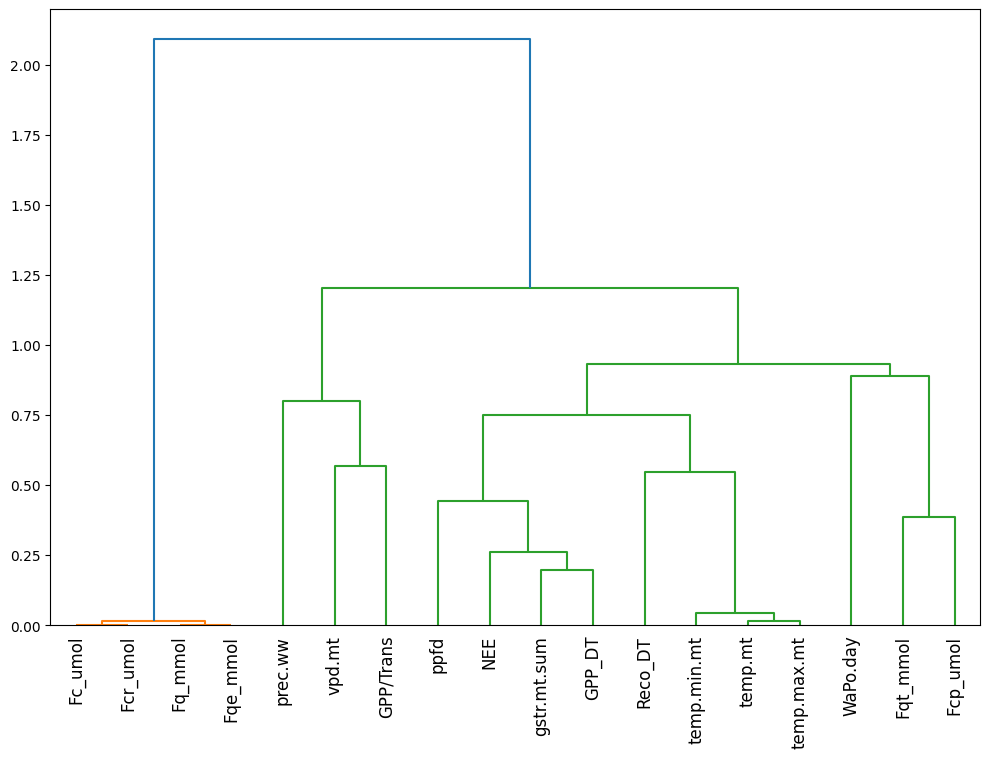

In [38]:
dendro = utils.dispaly_cluster_dendrogram(df)

In [ ]:
target = 'NEE'

_ = df.copy()
_ = df.dropna(subset=target)
y = _[target]
X = _.drop(columns=targets.columns.to_list())

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=.7, shuffle=True, random_state=42)

model = xgb.XGBRegressor(n_estimators=2500, 
                         max_depth=4, 
                         learning_rate=.03, gamma=14, 
                         early_stopping_rounds=50, 
                         min_child_weight=3, 
                         colsample_bytree=1, 
                         subsample=.5, 
                         eval_metric=root_mean_squared_error)

model.fit(X_train, y_train, eval_set=[(X_test, y_test)])

In [ ]:
preprocessor = Pipeline([
    ('impute', SimpleImputer()),
    ('scaler', StandardScaler())
])
pipe = Pipeline([
    ('preprocessor', preprocessor),
    ('model', MLPRegressor(hidden_layer_sizes=(10, 20, )))
    ])
pipe.fit(X_train, y_train)
print(r2_score(y_test, pipe.predict(X_test)))
explainer = shap.KernelExplainer(
    pipe['model'].predict,
    shap.kmeans(X_train, 10)
)
shap_values = explainer.shap_values(preprocessor.transform(X_train))

In [ ]:
r2_score(y_test, model.predict(X_test))

In [ ]:
# explainer = shap.KernelExplainer(
#     model.predict,
#     shap.kmeans(X_train, 10)
#     )
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_train)

In [ ]:
shap.summary_plot(shap_values, X_train, plot_type="dot")

In [ ]:
shap_values_doy = pd.DataFrame(shap_values).groupby(X_train.index.day_of_year).mean().to_numpy()
features_doy = features[X_train.columns].groupby(features.index.day_of_year).mean()
targets_doy = targets.groupby(pd.to_datetime(targets.index).day_of_year).mean()

In [ ]:
sorted = pd.DataFrame(np.abs(shap_values_doy), columns=features_doy.columns).mean().sort_values(ascending=False).index.to_list()

In [ ]:
shap_melt = pd.DataFrame(shap_values_doy, columns=features_doy.columns).melt(ignore_index=False)

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(15,8), dpi=500)
sns.barplot(data=shap_melt, x=shap_melt.index, y='value', hue='variable', dodge=False, palette='magma_r', fill=True, gap=0, width=.95, hue_order=sorted, alpha=1.0, edgecolor="none", saturation=1)
plt.plot(targets_doy[target], label=target, color='black', linestyle='--')
ticks = ax.set_xticks(list(np.arange(0,375,25)))
ticks_lab = ax.set_xticklabels(list(np.arange(0,375,25)))
plt.margins(x=0)
sns.set_style('dark')
plt.tight_layout()
plt.legend()


In [ ]:
fig, ax = plt.subplots(1,1, figsize=(15,8), dpi=500)
i=0
for variable in sorted:
    plt.bar(features_doy.index, shap_melt[shap_melt["variable"]==variable].value, label=variable, color=sns.color_palette("magma_r")[i], width=1, alpha=.5)
    i += 1
plt.plot(targets_doy[target], label=target, color='black', linestyle='--')
plt.margins(x=0)
plt.tight_layout()
plt.legend()


In [ ]:
explainer.expected_value

In [ ]:
df.NEE.mean()

In [ ]:
shap.waterfall_plot(
    shap.Explanation(
        values=shap_values_doy[365, :],
        base_values=explainer.expected_value,
        data=features_doy.iloc[365, :],
        feature_names=features_doy.columns
    )
)

In [ ]:
plt.barh(list(X_train.columns), shap_values.mean(axis=0))

In [ ]:
rfecv = RFECV(model, min_features_to_select=1, cv=5)
rfecv.fit(X_train, y_train)

In [ ]:
data = {
    key: value
    for key, value in rfecv.cv_results_.items()
    if key in ["n_features", "mean_test_score", "std_test_score"]
}
cv_results = pd.DataFrame(data)
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Mean test accuracy")
plt.errorbar(
    x=cv_results["n_features"],
    y=cv_results["mean_test_score"],
    yerr=cv_results["std_test_score"],
)
plt.title("Recursive Feature Elimination \nwith correlated features")
plt.show()

In [ ]:
X_train.columns[rfecv.support_]

In [ ]:
utils.plot_gini_permutation_importance(model, X_train, y_train)